In [1]:
#image analysis
import sys
sys.path.append("../../")

import skimage.io
import imageio
import alienlab.plot
from alienlab.improcessing import normalize, grey_to_rgb, make_binary
import alienlab.segment
from alienlab.fo import FramesOperator
import alienlab.io
from scipy import optimize
import glob
from alienlab.regression_func import *
import copy
from VoltageIntensityClass import VoltageIntensity
from tqdm import tqdm

from joblib.externals.loky import set_loky_pickler
from joblib import parallel_backend
from joblib import Parallel, delayed
from joblib import wrap_non_picklable_objects
from skimage.transform import resize

import pandas as pd

import mvgavg

import scipy

import tifffile as tiff

#interactive widget packages
from ipywidgets import interact, interactive, fixed, interact_manual
from tkinter.filedialog import askopenfilename, askdirectory

from VoltageIntensityClass import VoltageIntensity


import time
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg  # Using the ipython notebook widgets
from alienlab.regression_func import platt, residuals
from alienlab.utils import clip
from alienlab.segment import uniform_mask, label_to_data
from alienlab.widget import click_to_graph
#%matplotlib inline


from mvgavg import mvgavg

p = alienlab.plot.PlotFigure()
p.extension = ".png"
p.date = False
p.save_folder = "G:/DREAM/from_github/thesis/Figures/OJIP/"
p.figsize = (10,5)
p.fontsize = 18
p.fonttick = 12



In [2]:
#file_path = "ENTER NAME OF THE FILE YOU DROPPED IN THE FILE SECTION HERE" 
file_folder = 'G:/DREAM/from_github/PAMFluo/Experiments/FOLDER_2021_11_03_OJIP_calibration/FOLDER_2021_11_03_OJIP_actiivated_1/'
#askdirectory(title = 'Select an experiment folder', initialdir="G:/DREAM/from_github/PAMFluo/Experiments")  # pops up a window to select your file 
# uncomment this line if you use this jupyter notebook locally
#'G:/DREAM/from_github/PAMFluo/Experiments/2021-06-24_12_12_Ek_video'
file_folder

'G:/DREAM/from_github/PAMFluo/Experiments/FOLDER_2021_11_03_OJIP_calibration/FOLDER_2021_11_03_OJIP_actiivated_1/'

In [3]:
def get_fit(decay, time, give_y = False):    

    time_spread = time.max()-time.min()
    start = np.mean(decay[0])
    stop = np.mean(decay[-10:])
    x0 = [start, 1/10, stop]

    parameters_estimated = optimize.least_squares(residuals,  x0, bounds = (-1e8,1e8),
                                args = (time, decay, exp_decay))
    
    if give_y:
        return np.array(parameters_estimated.x), exp_decay(parameters_estimated.x, time)
    else:
        return np.array(parameters_estimated.x)

def make_fit(decay, time_array):
    params, ypred = get_fit(decay, time_array, give_y = True)
    plt.plot(time_array, ypred, label = params[1])
    plt.plot(time_array, decay, '.')
    plt.xlabel("intensity (µeins/m²/s))")
    plt.ylabel("fluorescence")
    #plt.legend()
    


In [4]:
os.listdir(file_folder)

['2021-11-03_19_59_OJIP_pulse',
 '2021-11-03_20_01_OJIP_pulse',
 '2021-11-03_20_02_OJIP_pulse',
 '2021-11-03_20_03_OJIP_pulse',
 '2021-11-03_20_04_OJIP_pulse',
 '2021-11-03_20_06_OJIP_pulse',
 '2021-11-03_20_08_OJIP_pulse',
 '2021-11-03_20_09_OJIP_pulse',
 '2021-11-03_20_10_OJIP_pulse',
 '2021-11-03_20_12_OJIP_pulse']

['FOLDER_2021_11_03_OJIP_actiivated_1\\2021-11-03_19_59_OJIP_pulse']
['FOLDER_2021_11_03_OJIP_actiivated_1\\2021-11-03_20_01_OJIP_pulse']
['FOLDER_2021_11_03_OJIP_actiivated_1\\2021-11-03_20_02_OJIP_pulse']
['FOLDER_2021_11_03_OJIP_actiivated_1\\2021-11-03_20_03_OJIP_pulse']
['FOLDER_2021_11_03_OJIP_actiivated_1\\2021-11-03_20_04_OJIP_pulse']
['FOLDER_2021_11_03_OJIP_actiivated_1\\2021-11-03_20_06_OJIP_pulse']
['FOLDER_2021_11_03_OJIP_actiivated_1\\2021-11-03_20_08_OJIP_pulse']
['FOLDER_2021_11_03_OJIP_actiivated_1\\2021-11-03_20_09_OJIP_pulse']
['FOLDER_2021_11_03_OJIP_actiivated_1\\2021-11-03_20_10_OJIP_pulse']
['FOLDER_2021_11_03_OJIP_actiivated_1\\2021-11-03_20_12_OJIP_pulse']
['FOLDER_2021_11_03_OJIP_activated_2\\2021-11-03_20_14_OJIP_pulse']
['FOLDER_2021_11_03_OJIP_activated_2\\2021-11-03_20_16_OJIP_pulse']
['FOLDER_2021_11_03_OJIP_activated_2\\2021-11-03_20_17_OJIP_pulse']
['FOLDER_2021_11_03_OJIP_activated_2\\2021-11-03_20_18_OJIP_pulse']
['FOLDER_2021_11_03_OJIP_activated_2\\

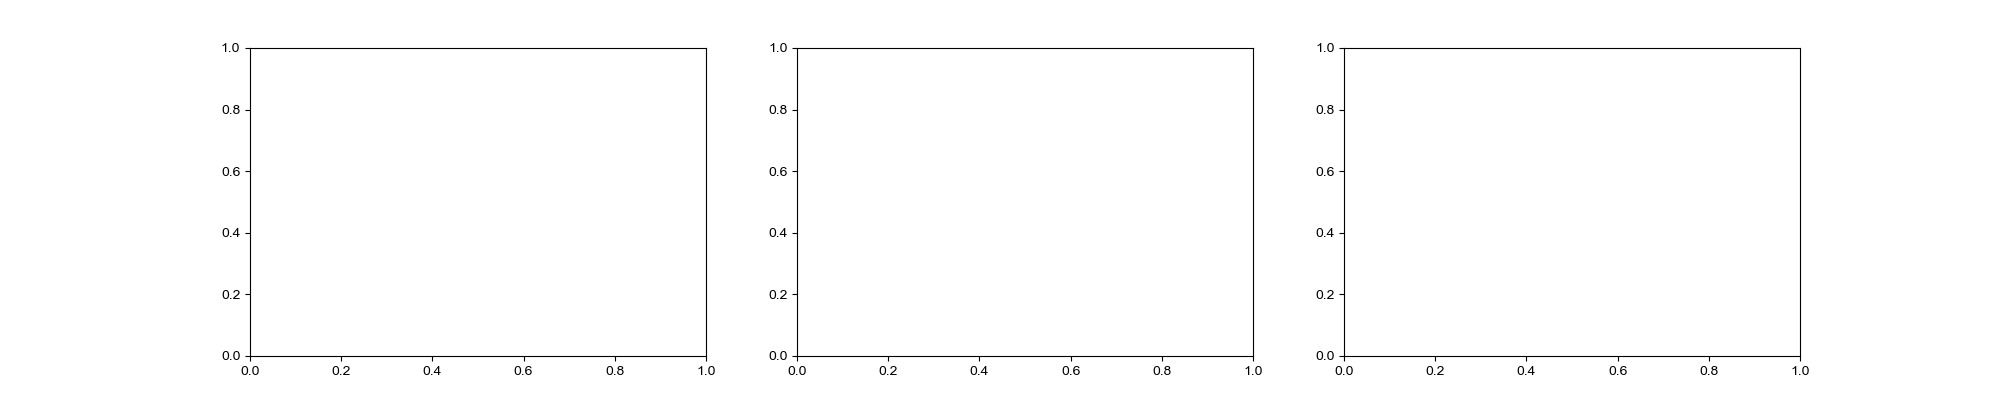

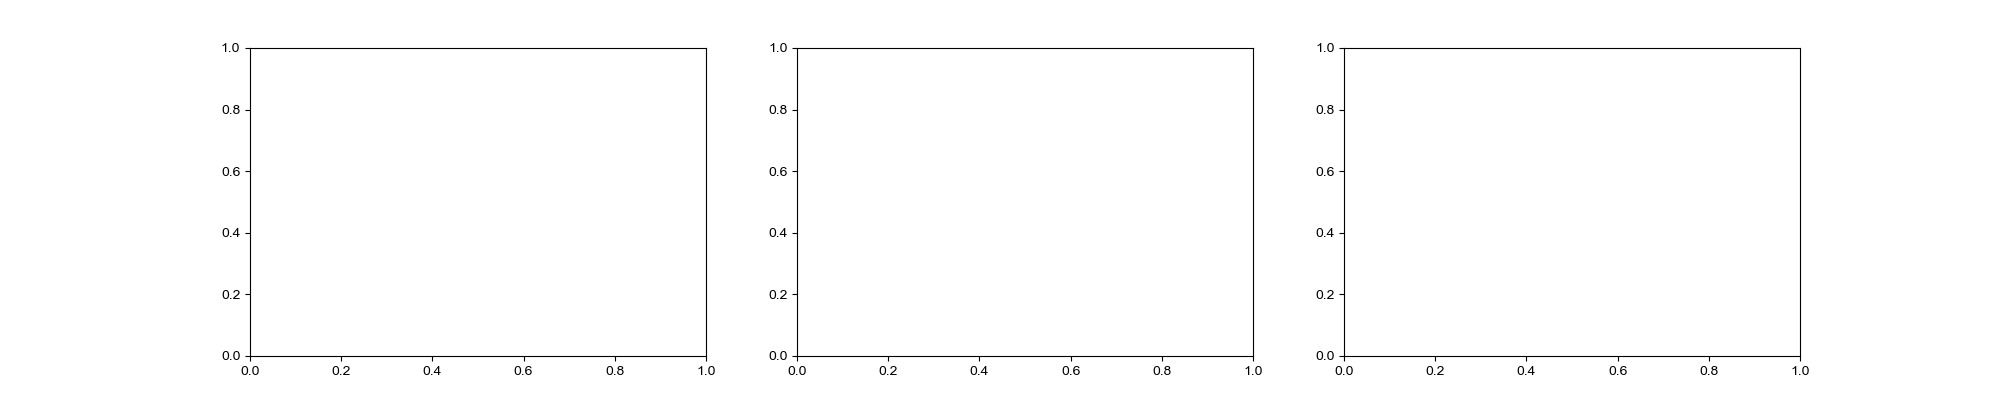

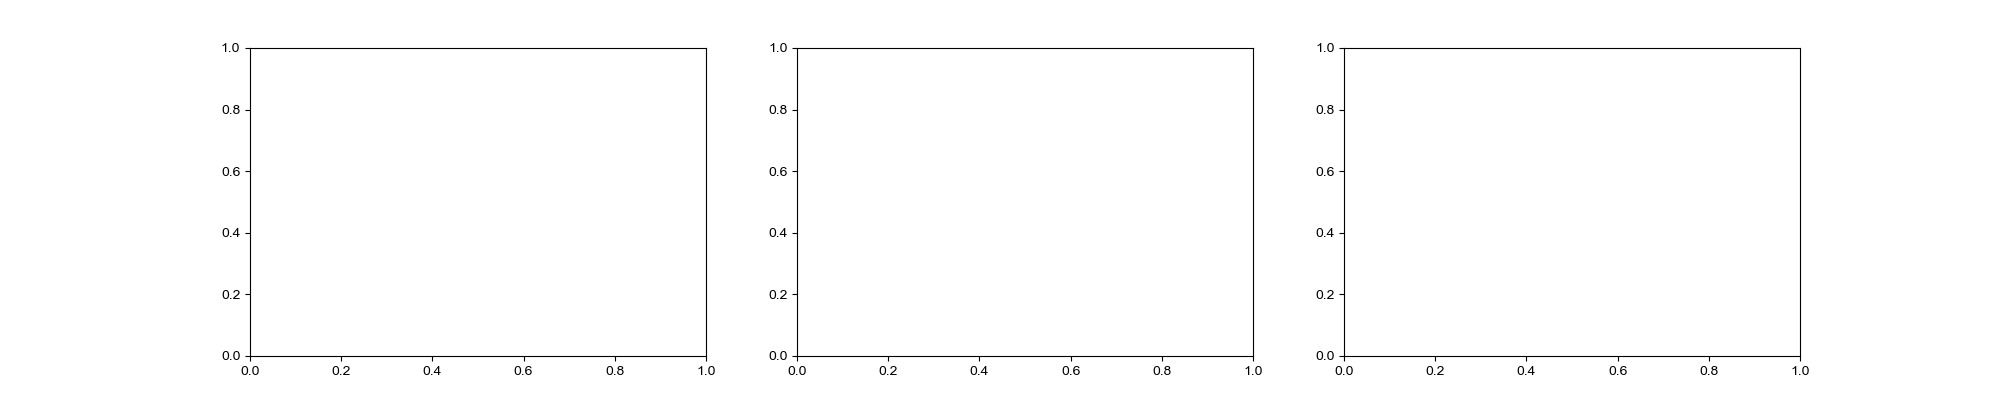

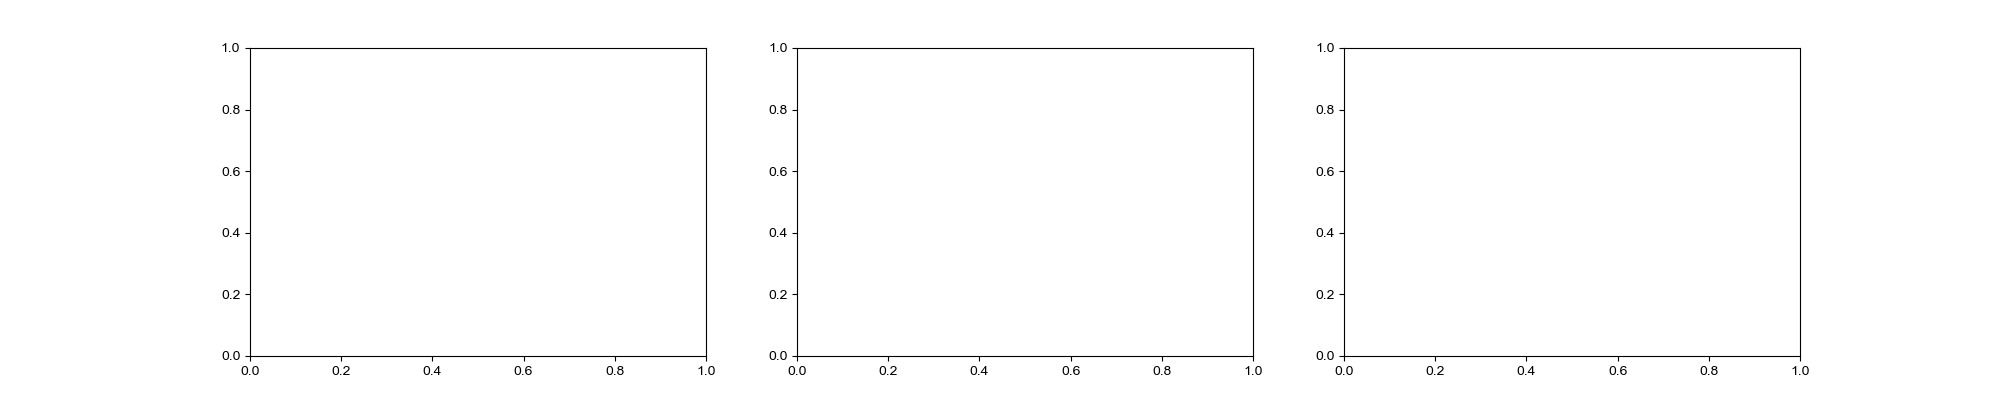

In [5]:
folder_list = ['FOLDER_2021_11_03_OJIP_actiivated_1/', 'FOLDER_2021_11_03_OJIP_activated_2/', 'FOLDER_2021_11_03_OJIP_activated_3/', 'FOLDER_2021_11_03_OJIP_control/']

for file_folder in folder_list:

    fig, axs = plt.subplots(1, 3, figsize=(20, 4))

    XX = []
    YY = []
    #voltage = [3, 10, 30, 100, 150, 200, 250, 300, 350, 400, 3, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    NN = 20
    #filter_list = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5,  0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0, 0, 0, 0, 0, 0, 0,0]
    #voltage =  [5, 15, 25, 35, 45, 55, 65, 75, 85,  200, 250, 300,350, 400, 100, 100, 150 , 200, 250, 25, 5, 10]
    np.array(list(np.linspace(0, 450, NN))+list(np.linspace(0, 450, NN)))#[::-1]
    filter_list = [0,0,0,0, 0, 0, 0, 0,0, 0, 0, 0, 0]
    voltage = [500, 400, 300, 200, 100, 70, 40, 20, 10, 150]

    W = 1000
    start = 60
    stop = 3000

    for i, f in enumerate(glob.glob(file_folder + "/*")):
            print( glob.glob(f))
            file_path = glob.glob(f + "/*_ojip_curve.csv")[0] # pops up a window to select your file
            file2 = glob.glob(f + "/*_ojip_curve.csv")[0]
            data_sequence = pd.read_csv(file_path)
            amp_seq = pd.read_csv(file2)

            V = VoltageIntensity(folder = "G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram")
            intensity = V.get_intensity_voltage('blue', filter_list[i], voltage[i]/100)*1e6
            #fluo = amplitude

            if voltage[i] >0 and filter_list[i]>-1:


                time_array = np.array(data_sequence["time (s) intensity"])
                fluo = np.array(data_sequence["voltage (V) intensity"])
                xrange = (fluo > 0.04)*(time_array<0.0006)
                #fluo = fluo/np.mean(fluo[-200:])#*intensity
                amplitude = np.array(amp_seq["voltage (V) intensity"])
                #intensity = np.mean(amplitude[1500:2000])


                xrange = (fluo>0.006)*(time_array<(0.006/np.sqrt(voltage[i])*3))
                x = time_array[xrange]
                y = fluo[xrange]

                W = 100
                x = mvgavg(x, W)
                y = mvgavg(y, W)
            
                #axs[0].plot(x*1000, y, '.' , label = voltage[i])
                params, ypred = get_fit(y, x, give_y = True)
                """
                axs[0].plot(x*1000, ypred, '-')
                axs[0].set_xlabel("time(ms)")
                axs[0].set_ylabel("fluorescence")
                axs[1].scatter(intensity, 1/params[1])
                axs[1].set_xlabel("intensity (µeins/m²/s)")
                axs[1].set_ylabel("rate (1/tau)") 
                """
                XX.append(intensity)
                YY.append(1/params[1])
                
                #axs[2].plot(amplitude, label = voltage[i])
                #axs[0].legend()
                #axs[2].legend()
            
    np.save("%s.npy"%file_folder[18:-1], np.array([XX,YY]))
            #axs[3].scatter(voltage[i], FQ, color = 'r')
    #plt.legend()


In [6]:
file_folder[18:]

'OJIP_control/'

In [6]:
V1 = VoltageIntensity(folder = "G:/DREAM/from_github/PAMFluo/Experiments/2021-10-28_14_17_bode_diagram")

for i in [80, 85, 90, 95, 100, 105, 80]:
    print("HL:",V1.get_intensity_voltage("blue", 0.5, i/100)*1e6)
    if int(i-80)==0:
        print("LL:",0)
    else:
        print("LL:",V1.get_intensity_voltage("blue", 0.5, (i-80)/100)*1e6)
        
        
V1 = VoltageIntensity(folder = "G:/DREAM/from_github/PAMFluo/Experiments/2021-11-03_15_54_bode_diagram")

for i in [80, 85, 90, 95, 100, 105, 80]:
    print("HL:",V1.get_intensity_voltage("blue", 0.5, i/100)*1e6)
    if int(i-80)==0:
        print("LL:",0)
    else:
        print("LL:",V1.get_intensity_voltage("blue", 0.5, (i-80)/100)*1e6)

for i in [10, 20, 40, 60, 100, 150, 200, 250, 300, 400, 500]:
    print("HL:",V1.get_intensity_voltage("blue", 1, i/100)*1e6)


IndexError: list index out of range

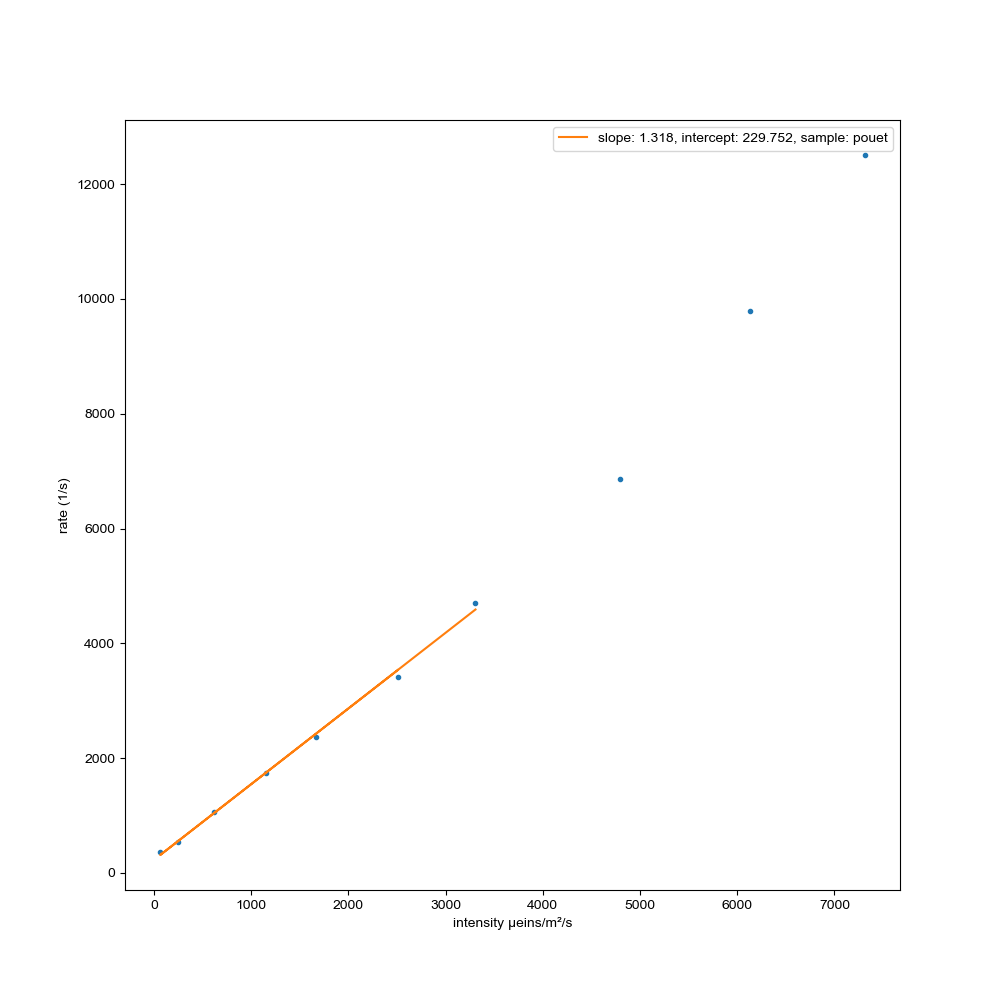

In [7]:
from alienlab.regression_func import regression_affine
start =  3
stop = 10
plt.figure(figsize = (10,10))
Yreg, a, b, pp = regression_affine(np.array(XX[start:stop]), np.array(YY[start:stop]))
plt.plot(XX, YY, '.')
file = "pouet"
plt.plot(XX[start:stop] ,Yreg, '-', label = "slope: %0.3f, intercept: %0.3f, sample: %s"%(a, b,file))
plt.xlabel("intensity µeins/m²/s")
plt.ylabel("rate (1/s)")
plt.legend()



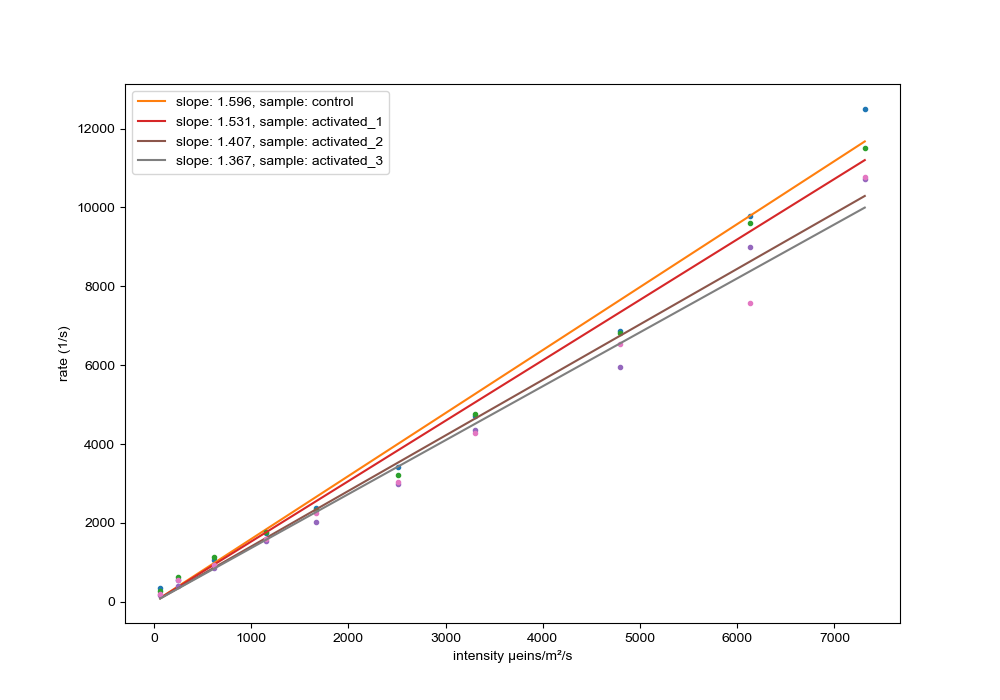

In [8]:
from alienlab.regression_func import regression_affine
start = 0# 2
stop = -1
plt.figure(figsize = (10,7))
totX = []
totY = []
for file in ["control", "activated_1", "activated_2", "activated_3"]:
    filepath = "OJIP_"+file+".npy"
    [XX,YY] = np.load(filepath)
    totX.append(XX)
    totY.append(YY)
    Yreg, a, pp = regression_linear(np.array(XX[start:stop]), np.array(YY[start:stop]))
    plt.plot(XX, YY, '.')
    plt.plot(XX[start:stop] ,Yreg, '-', label = "slope: %0.3f, sample: %s"%(a, file))
    plt.xlabel("intensity µeins/m²/s")
    plt.ylabel("rate (1/s)")
plt.legend()


pp

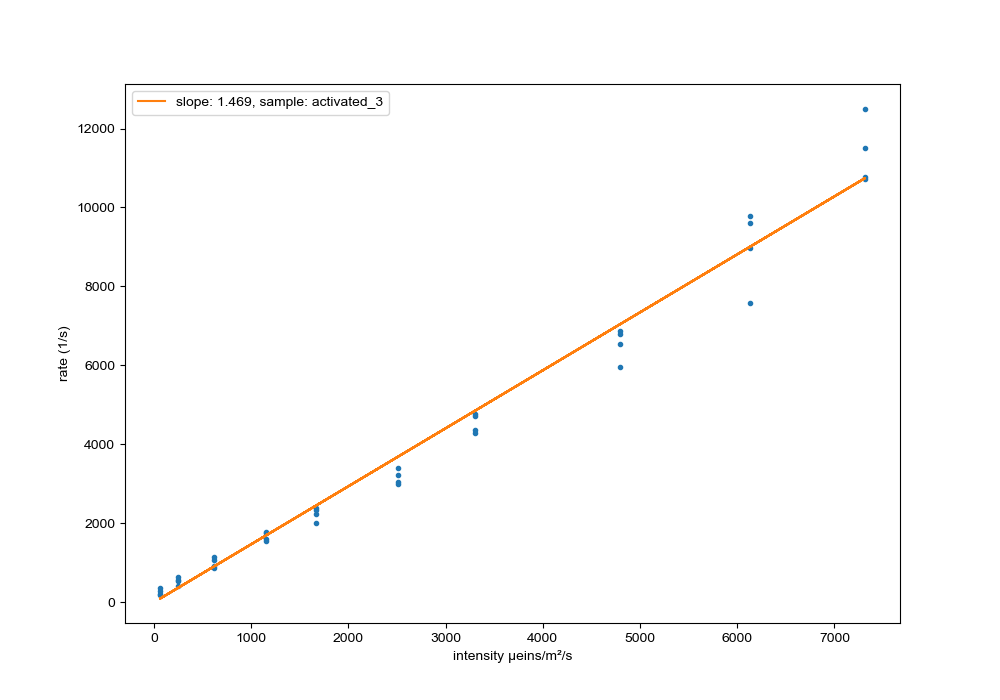

In [9]:
plt.figure(figsize = (10,7))

X_calib=np.concatenate(totX)
Y_calib=np.concatenate(totY)
Yreg, a, pp = regression_linear(np.array(X_calib[start:stop]), np.array(Y_calib[start:stop]))
plt.plot(X_calib, Y_calib, '.')
plt.plot(X_calib[start:stop] ,Yreg, '-', label = "slope: %0.3f, sample: %s"%(a, file))
plt.xlabel("intensity µeins/m²/s")
plt.ylabel("rate (1/s)")
plt.legend()



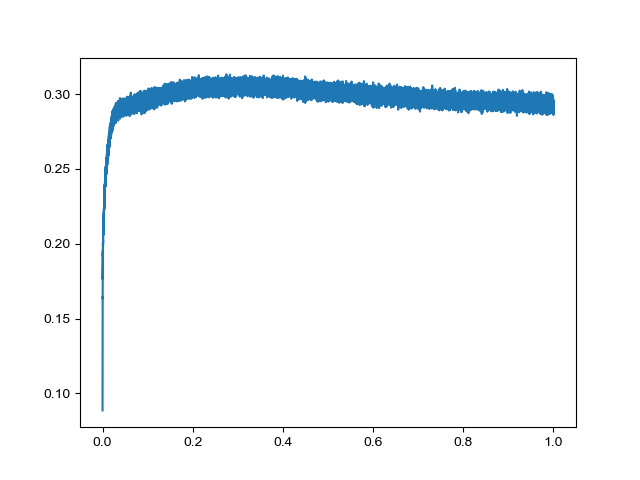

In [10]:
plt.figure()
time_array = np.array(data_sequence["time (s) intensity"])
fluo = np.array(data_sequence["voltage (V) intensity"])
xrange = fluo>0.006
x = time_array[xrange]
y = fluo[xrange]
        
W = 100
x = mvgavg(x, W)
y = mvgavg(y, W)
            
plt.plot(x, y)

### Data Yuxi

In [11]:
activated =  np.array([[20,775],
[30,924],
[40,1161],
[50,1482],
[60,1912],
[70,2323],
[80,2777],
[90,3173]])

control = np.array([[90, 3482],
[80,3079],
[70,2610],
[60,2116],
[50,1659],
[40,1208],
[30,938],
[20,890]])

X_instr = np.concatenate([activated[:,0], control[:,0]])
Y_instr = np.concatenate([activated[:,1], control[:,1]])

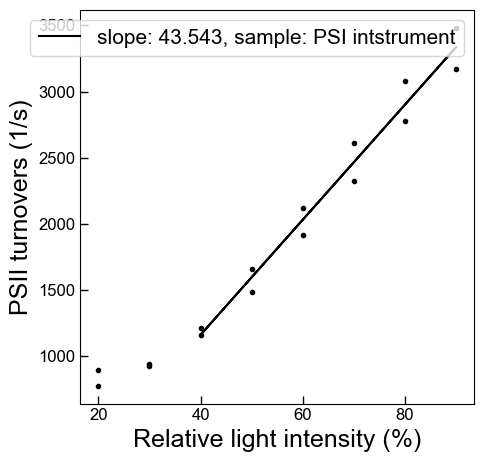

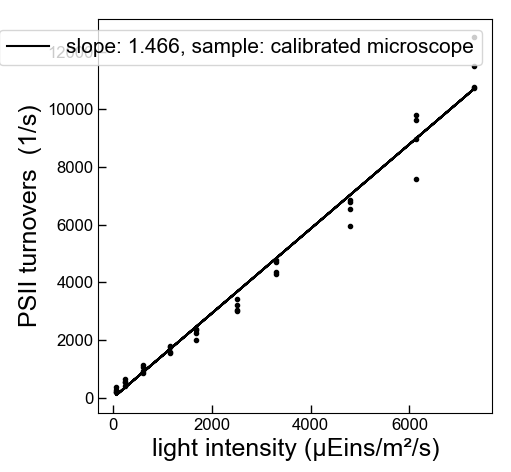

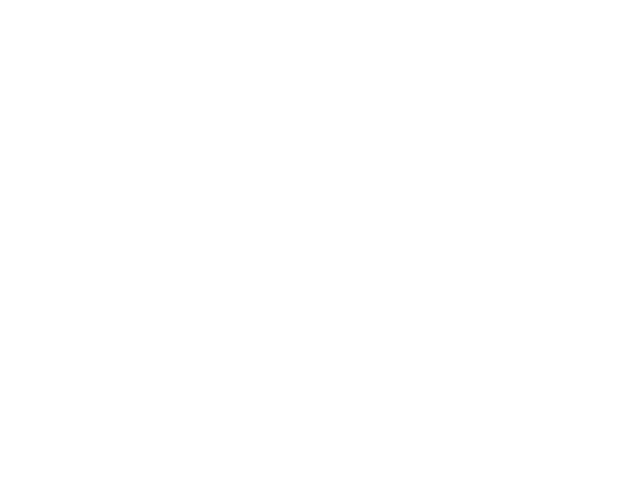

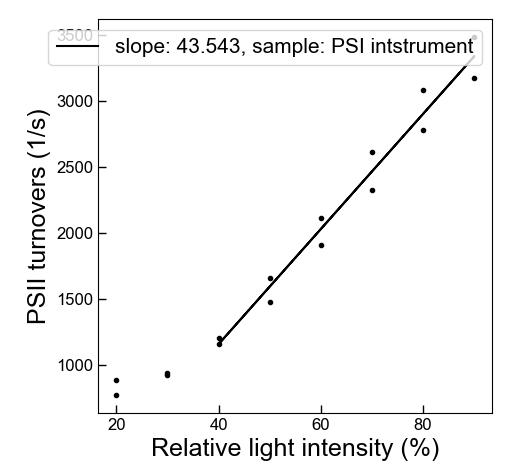

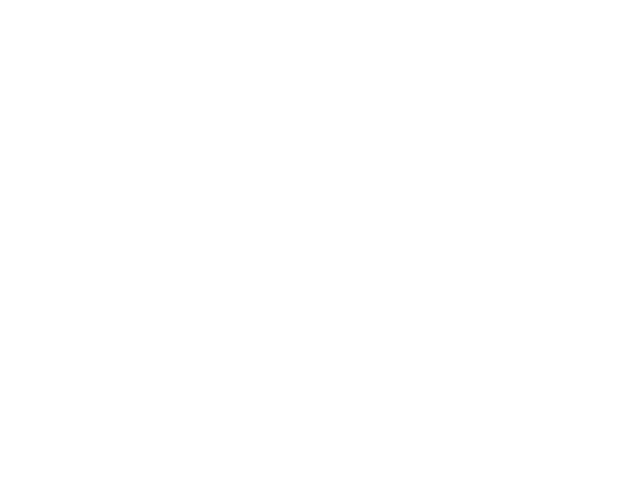

In [12]:
p.figsize=(8,8)
p.xlabel = 'light intensity (µEins/m²/s)'
p.ylabel  = 'PSII turnovers  (1/s)'
fig = p.set_figure("%d", "%d")

ind = X_calib<8000
Yreg, a_calib, pp = regression_linear(np.array(X_calib[ind]), np.array(Y_calib[ind]))
plt.plot(X_calib[ind], Y_calib[ind], '.k')
plt.plot(X_calib[ind] ,Yreg, '-k', label = "slope: %0.3f, sample: %s"%(a_calib, "calibrated microscope"))
plt.legend(prop = {"size":15})
p.save_name = "calibrated_microscope"
p.saving(fig)

ind_instr = X_instr>30
X_instr = np.array(X_instr)
Y_instr =  np.array(Y_instr)
Yreg, a_instr, b, pp = regression_affine(X_instr[ind_instr], Y_instr[ind_instr])

alpha  = 1#a0/a1

fig = p.set_figure("%d", "%d")

plt.plot(X_instr*alpha, Y_instr, '.k')
plt.plot(X_instr[ind_instr]*alpha ,Yreg, '-k', label = "slope: %0.3f, sample: %s"%(a_instr, "PSI intstrument" ))



plt.xlabel("Relative light intensity (%)")
plt.ylabel("PSII turnovers (1/s)")
plt.legend(prop = {"size":15})
p.save_name="PSI_insrument_mono_fit_Yuxi"
p.saving(fig)

FileNotFoundError: [Errno 2] No such file or directory: 'spectra/spectra_chlamy.npy'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


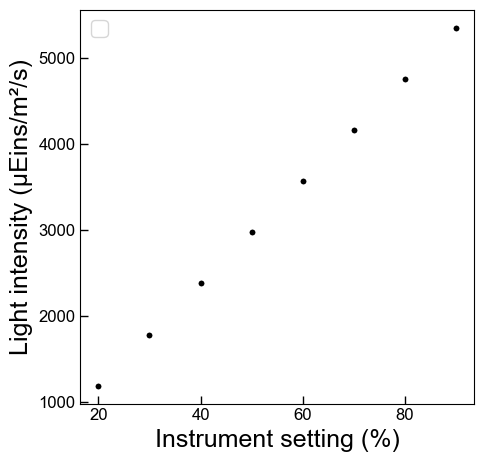

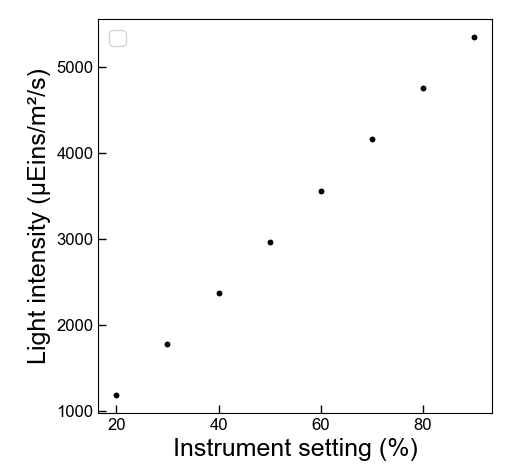

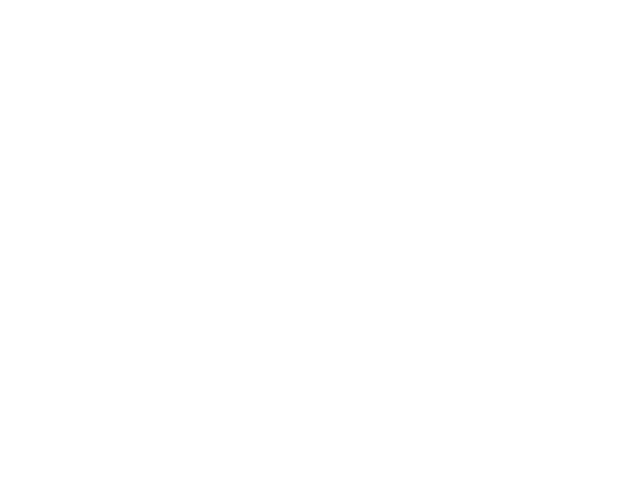

In [13]:
p.figsize=(10,10)
p.ylabel = 'Light intensity (µEins/m²/s)'
p.xlabel  = 'Instrument setting (%)'
fig = p.set_figure("%d", "%d")



plt.plot(X_instr, X_instr*a_instr/a_calib*2, '.k')
plt.legend(prop = {"size":15})
p.save_name = "setting_equvalency"
p.saving(fig)


